##### Adapted from the official TensorFlow documentation. Copyright 2020 The TensorFlow Authors.

In [37]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

# TensorFlow basics

## Tensors

TensorFlow operates on multidimensional arrays or _tensors_ represented as `tf.Tensor` objects. Here is a two-dimensional tensor:

In [38]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


The most important attributes of a `tf.Tensor` are its `shape` and `dtype`:

* `Tensor.shape`: tells you the size of the tensor along each of its axes.
* `Tensor.dtype`: tells you the type of all the elements in the tensor.

TensorFlow implements standard mathematical operations on tensors, as well as many operations specialized for machine learning. Many operations have an identical syntax as found in NumPy.

For example:

In [39]:
x + x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [40]:
5 * x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [41]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [42]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [43]:
tf.nn.softmax(x, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.66524094],
       [0.09003057, 0.24472848, 0.66524094]], dtype=float32)>

In [44]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

Note: Typically, anywhere a TensorFlow function expects a `Tensor` as input, the function will also accept anything that can be converted to a `Tensor` using `tf.convert_to_tensor`. See below for an example.

In [45]:
tf.convert_to_tensor([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [46]:
tf.reduce_sum([1,2,3])

<tf.Tensor: shape=(), dtype=int32, numpy=6>

Running large calculations on CPU can be slow. When properly configured, TensorFlow can use accelerator hardware like GPUs to execute operations very quickly.

In [47]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


### Conversion to NumPy

You can convert a tensor to a NumPy array either using `np.array` or the `tensor.numpy` method:

In [48]:
import numpy as np

np.array(x)
# or
x.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

## Variables

Normal `tf.Tensor` objects are immutable. To store model weights (or other mutable state) in TensorFlow use a `tf.Variable`.

In [49]:
var = tf.Variable([0.0, 0.0, 0.0])

In [50]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [51]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

A variable looks and acts like a tensor, and, in fact, is a data structure backed by a `tf.Tensor`.
Most tensor operations work on variables.

## Automatic differentiation

TensorFlow implements automatic differentiation (autodiff), which uses calculus to compute gradients. Typically you'll use this to calculate the gradient of a model's _error_ or _loss_ with respect to its weights.

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation.

In [52]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [53]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

At `x = 1.0`, `y = f(x) = (1**2 + 2*1 - 5) = -2`.

The derivative of `y` is `y' = f'(x) = (2*x + 2) = 4`. TensorFlow can calculate this automatically:

In [54]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

This simplified example only takes the derivative with respect to a single scalar (`x`), but TensorFlow can compute the gradient with respect to any number of non-scalar tensors simultaneously.

In [55]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print(dl_db)

tf.Tensor([-3.7098799 -0.8962367], shape=(2,), dtype=float32)


Alternatively, we can pass a dictionary of variables:

In [56]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-3.7098799, -0.8962367], dtype=float32)>

*Note*: By default, the resources held by a GradientTape are released as soon as the GradientTape.gradient method is called. To compute multiple gradients over the same computation, create a gradient tape with persistent=True. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected.

Although variables are important for differentiation, some variables will not need to be differentiated. You can turn off gradients for a variable by setting trainable to false at creation. An example of a variable that would not need gradients is a training step counter.


In [57]:
step_counter = tf.Variable(1, trainable=False)

### Gradients of non-scalar targets and Jacobian

If the target(s) are not scalar the gradient of the sum is calculated. If you need a separate gradient for each item, use Jacobians.

In [58]:
x = tf.linspace(-10.0, 10.0, 5)
w = tf.Variable([0.0,1.0])
with tf.GradientTape(persistent=True) as tape:
  y = (x+w[0]-2*w[1])**3

print(tape.gradient(y, w).numpy()) # not what you expect, probably
print(tape.jacobian(y, w).numpy())

[  810. -1620.]
[[ 432. -864.]
 [ 147. -294.]
 [  12.  -24.]
 [  27.  -54.]
 [ 192. -384.]]


## Graphs and tf.function

While you can use TensorFlow interactively like any Python library, TensorFlow also provides tools for:

* **Performance optimization**: to speed up training and inference.
* **Export**: so you can save your model when it's done training.

These require that you use `tf.function` to separate your pure-TensorFlow code from Python.

In [59]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

The first time you run the `tf.function`, although it executes in Python, it captures a complete, optimized graph representing the TensorFlow computations done within the function.

In [60]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

On subsequent calls TensorFlow only executes the optimized graph, skipping any non-TensorFlow steps. Below, note that `my_func` doesn't print _tracing_ since `print` is a Python function, not a TensorFlow function.

In [61]:
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

A graph may not be reusable for inputs with a different _signature_ (`shape` and `dtype`), so a new graph is generated instead:

In [62]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

## Modules, layers, and models

`tf.Module` is a class for managing your `tf.Variable` objects, and the `tf.function` objects that operate on them. The `tf.Module` class is necessary to support two significant features:

1. You can save and restore the values of your variables using `tf.train.Checkpoint`. This is useful during training as it is quick to save and restore a model's state.
2. You can import and export the `tf.Variable` values _and_ the `tf.function` graphs using `tf.saved_model`. This allows you to run your model independently of the Python program that created it.

Here is a complete example exporting a simple `tf.Module` object:

In [63]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [64]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

Save the `Module`:

In [65]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved/assets


The resulting SavedModel is independent of the code that created it. You can load a SavedModel from Python, other language bindings, or [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/docker). You can also convert it to run with [TensorFlow Lite](https://www.tensorflow.org/lite/guide) or [TensorFlow JS](https://www.tensorflow.org/js/guide).

In [66]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

The `tf.keras.layers.Layer` and `tf.keras.Model` classes build on `tf.Module` providing additional functionality and convenience methods for building, training, and saving models. Some of these are demonstrated in the next section.

## Training loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [67]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

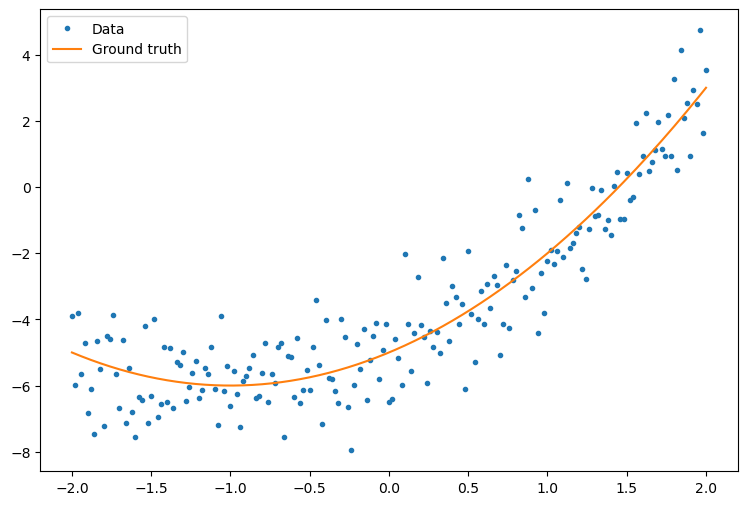

In [68]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

Create a quadratic model with randomly initialized weights and a bias:

In [69]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])
  
  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

First, observe your model's performance before training:

In [70]:
quad_model = Model()

In [71]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

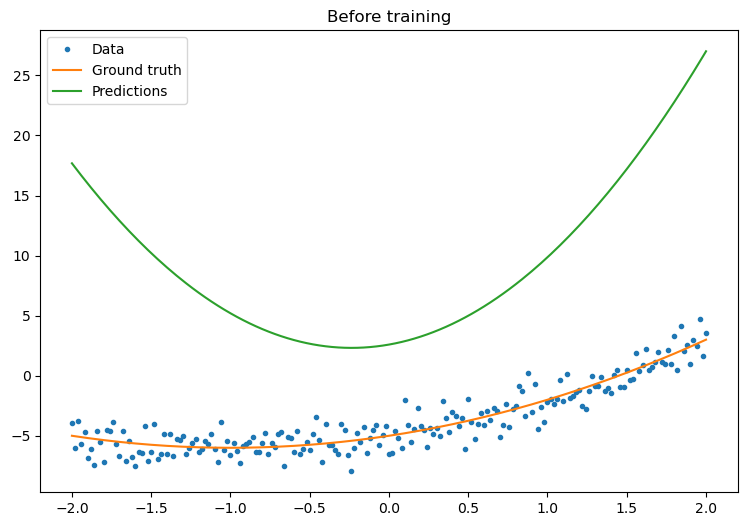

In [72]:
plot_preds(x, y, f, quad_model, 'Before training')

Now, define a loss for your model:

Given that this model is intended to predict continuous values, the mean squared error (MSE) is a good choice for the loss function. Given a vector of predictions, $\hat{y}$, and a vector of true targets, $y$, the MSE is defined as the mean of the squared differences between the predicted values and the ground truth.

$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$

In [73]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop for the model. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling.

In [74]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 68.926
Mean squared error for step 10: 4.200
Mean squared error for step 20: 2.167
Mean squared error for step 30: 1.426
Mean squared error for step 40: 1.182
Mean squared error for step 50: 1.094
Mean squared error for step 60: 1.067
Mean squared error for step 70: 1.058
Mean squared error for step 80: 1.053
Mean squared error for step 90: 1.052




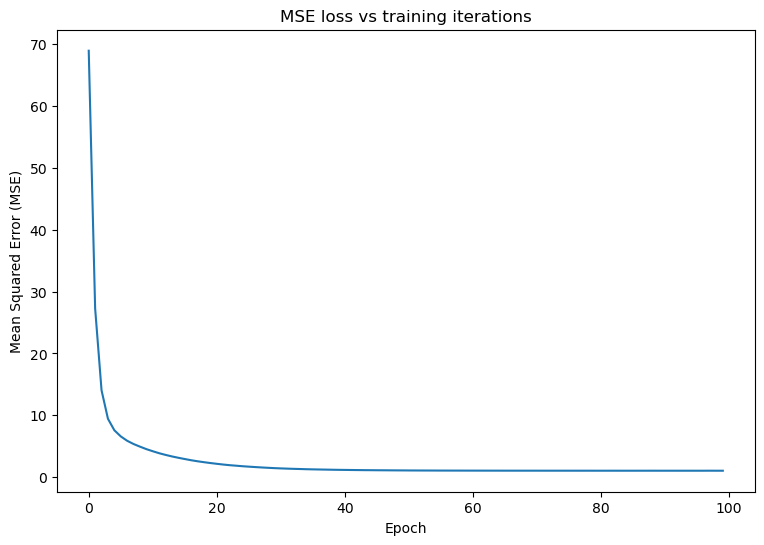

In [75]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      pred = quad_model(x_batch)
      batch_loss = mse_loss(pred, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

Now, observe your model's performance after training:

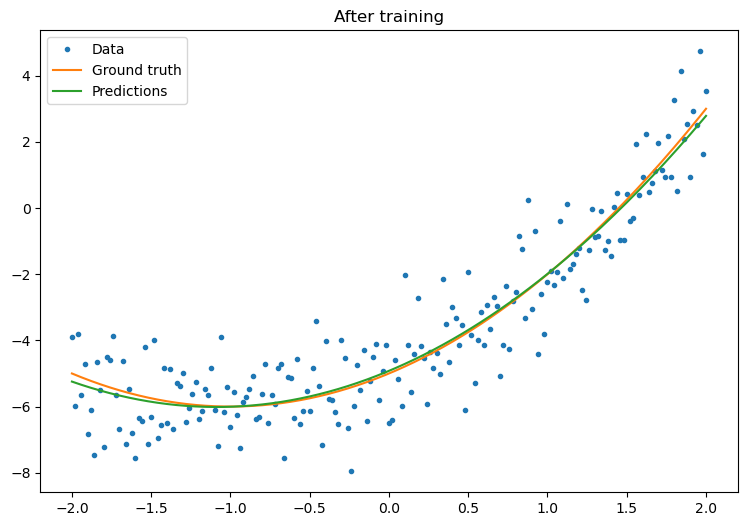

In [76]:
plot_preds(x, y, f, quad_model, 'After training')

That's working, but remember that implementations of common training utilities are available in the `tf.keras` module. So, consider using those before writing your own. 